# Leer datasets

In [11]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
glass = fetch_ucirepo(id=42) 

glass = glass.data.features 
#drop null values
glass = glass.dropna()
print(glass.shape)
glass.head()

(214, 9)


,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0


# Realizamos los clusters

In [12]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, SpectralClustering, AffinityPropagation, Birch, OPTICS, BisectingKMeans
from sklearn.mixture import GaussianMixture
n_clusters = 6
clustering_algorithms = {
    'KMeans': KMeans(n_clusters=n_clusters, random_state=42),
    'DBSCAN': DBSCAN(eps=0.7, min_samples=5),
    'AgglomerativeClustering': AgglomerativeClustering(n_clusters=n_clusters),
}
results = {}
for name, algorithm in clustering_algorithms.items():
    try:
        algorithm.fit(glass)
        if hasattr(algorithm, 'labels_'):
            labels = algorithm.labels_
        elif hasattr(algorithm, 'predict'):
            labels = algorithm.predict(glass)
        else:
            labels = algorithm.means_.argmax(axis=0)  # For GaussianMixture
        results[name] = labels
    except Exception as e:
        print(f"Error with {name}: {e}")

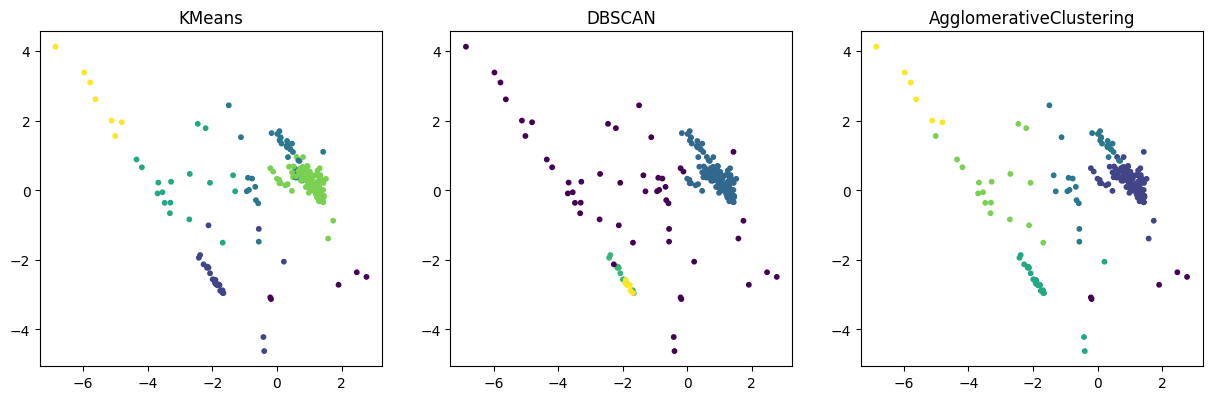

In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
glass_pca = pca.fit_transform(glass)
plt.figure(figsize=(15, 20))
for i, (name, labels) in enumerate(results.items(), 1):
    plt.subplot(4, 3, i)
    plt.scatter(glass_pca[:, 0], glass_pca[:, 1], c=labels, cmap='viridis', s=10)
    plt.title(name)

In [14]:
#definimos dunn index
def dunn_index(data, labels):
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        return 0.0

    inter_cluster_distances = []
    intra_cluster_distances = []

    for i in range(len(unique_labels)):
        for j in range(i + 1, len(unique_labels)):
            cluster_i = data[labels == unique_labels[i]]
            cluster_j = data[labels == unique_labels[j]]
            inter_distance = np.linalg.norm(cluster_i.mean(axis=0) - cluster_j.mean(axis=0))
            inter_cluster_distances.append(inter_distance)

        intra_distance = np.mean([np.linalg.norm(data[labels == unique_label] - data[labels == unique_label].mean(axis=0)) for unique_label in unique_labels])
        intra_cluster_distances.append(intra_distance)

    dunn_index_value = min(inter_cluster_distances) / max(intra_cluster_distances)
    return dunn_index_value

In [15]:
#podrias generar una metrica en que se calcule el valor maximo de distancia (entre las menores distancias de cada punto con otro dentro del mismo cluster) dividido por el valor minimo de distancia entre cualquier punto de un cluster con otro punto de otro cluster
import numpy as np
from sklearn.metrics import pairwise_distances

def custom_metric(X, labels):
    X = np.array(X)
    distances = pairwise_distances(X)
    n = len(X)
    
    # Numerador: máximo de las mínimas distancias dentro del mismo cluster
    max_min_intra = -np.inf
    for i in range(n):
        same_cluster = (labels == labels[i])
        same_cluster[i] = False  # Exclude itself
        if np.any(same_cluster):
            min_dist = np.min(distances[i][same_cluster])
            max_min_intra = max(max_min_intra, min_dist)
    
    # Denominador: mínima distancia entre puntos de distintos clusters
    min_inter = np.inf
    for i in range(n):
        other_cluster = (labels != labels[i])
        if np.any(other_cluster):
            min_dist = np.min(distances[i][other_cluster])
            min_inter = min(min_inter, min_dist)

    M = max_min_intra / min_inter if min_inter != 0 else np.inf
    return 1 /( 1 + M)


In [16]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from permetrics import ClusteringMetric
def evaluate_clustering(data, labels):
    if len(set(labels)) < 2:
        return {
            'Silhouette Score': None,
            'Calinski-Harabasz Score': None,
            'Davies-Bouldin Score': None,
            'Dunn Index': None,
            'custom_metric': None,
            'dbcv': None
        }
    
    silhouette = silhouette_score(data, labels)
    calinski_harabasz = calinski_harabasz_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    dunn = dunn_index(data.values, labels)
    custom = custom_metric(data.values, labels)
    dbcv = ClusteringMetric(X=data.values, y_pred=labels).DBCVI()

    return {
        'Silhouette Score': silhouette,
        'Calinski-Harabasz Score': calinski_harabasz,
        'Davies-Bouldin Score': davies_bouldin,
        'Dunn Index': dunn,
        'custom_metric': custom,
        'dbcv': dbcv
    }
evaluation_results = {}
for name, labels in results.items():
    evaluation_results[name] = evaluate_clustering(glass, labels)
evaluation_df = pd.DataFrame(evaluation_results).T
evaluation_df = evaluation_df.rename(columns={
    'Silhouette Score': 'Silhouette',
    'Calinski-Harabasz Score': 'Calinski-Harabasz',
    'Davies-Bouldin Score': 'Davies-Bouldin',
    'Dunn Index': 'Dunn',
    'custom_metric': 'Custom Metric'
})
evaluation_df

/home/dani/Documents/GitHub/Trabajo-dirigido-clustering/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dani/Documents/GitHub/Trabajo-dirigido-clustering/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Dunn,Custom Metric,dbcv
KMeans,0.448291,124.501447,0.967296,0.240735,0.043849,0.935693
DBSCAN,0.459371,45.050735,1.416482,0.117955,0.140101,NaN
AgglomerativeClustering,0.462192,118.711158,0.981729,0.242202,0.128723,0.927699


In [17]:
#elige los mejores 3 resultados ponderando el orden de cada métrica
def weighted_score(row):
    weights = {
        'Silhouette': 0.2,
        'Calinski-Harabasz': -0.2,
        'Davies-Bouldin': 0.2,  # Negativo porque queremos minimizar
        'Dunn': 0.2,
        'Custom Metric': 0.5 # Puedes ajustar este peso según su importancia
    }
    score = (row['Silhouette'] * weights['Silhouette'] +
                1/(1+row['Calinski-Harabasz']) * weights['Calinski-Harabasz'] +
                1/(1+row['Davies-Bouldin']) * weights['Davies-Bouldin'] +
                row['Dunn'] * weights['Dunn'] +
                row['Custom Metric'] * weights['Custom Metric'])
    return score
# Replace None values with 0 for scoring
evaluation_df_filled = evaluation_df.fillna(0)
evaluation_df_filled['Weighted Score'] = evaluation_df_filled.apply(weighted_score, axis=1)
top_3_algorithms = evaluation_df_filled.nlargest(3, 'Weighted Score')
top_3_algorithms

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Dunn,Custom Metric,dbcv,Weighted Score
AgglomerativeClustering,0.462192,118.711158,0.981729,0.242202,0.128723,0.927699,0.304491
DBSCAN,0.459371,45.050735,1.416482,0.117955,0.140101,0.000000,0.263938
KMeans,0.448291,124.501447,0.967296,0.240735,0.043849,0.935693,0.259798


# Interpretar

In [18]:
import sys
sys.path.append('../..')
from ripper import MultiClassRipperClassifier
from dsgd import DSClassifierMultiQ
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree as sk_tree

Processing AgglomerativeClustering with 6 clusters
Ripper Accuracy for AgglomerativeClustering: 0.86
Ripper Rules:

Reglas para clase: 0
[[RI=<1.5159^Si=<71.76]]

Reglas para clase: 1
[[RI=1.5174-1.5178] V [Al=1.44-1.54] V [Al=1.23-1.29] V [Mg=3.49-3.54] V [Mg=3.15-3.43^Ba=<0.56] V [Na=12.86-13.0] V [Mg=3.43-3.49] V [Al=1.29-1.35] V [K=0.52-0.56] V [K=0.62-0.68]]

Reglas para clase: 2
[[Ca=9.57-10.09] V [Ca=9.02-9.57^Mg=>3.8] V [Mg=1.74-3.15^Al=1.54-1.69]]

Reglas para clase: 3
[[Mg=<1.74^Ba=>0.56] V [Mg=<1.74^RI=1.5159-1.5164] V [RI=<1.5159^Mg=<1.74]]

Reglas para clase: 4
[[Ca=>10.09^RI=1.5187-1.5206] V [Ca=>10.09^RI=1.5206-1.5221] V [Ca=>10.09^Si=>73.27]]

Reglas para clase: 5
[[Na=<12.72^RI=>1.5221]]
Decision Tree Accuracy for AgglomerativeClustering: 0.88


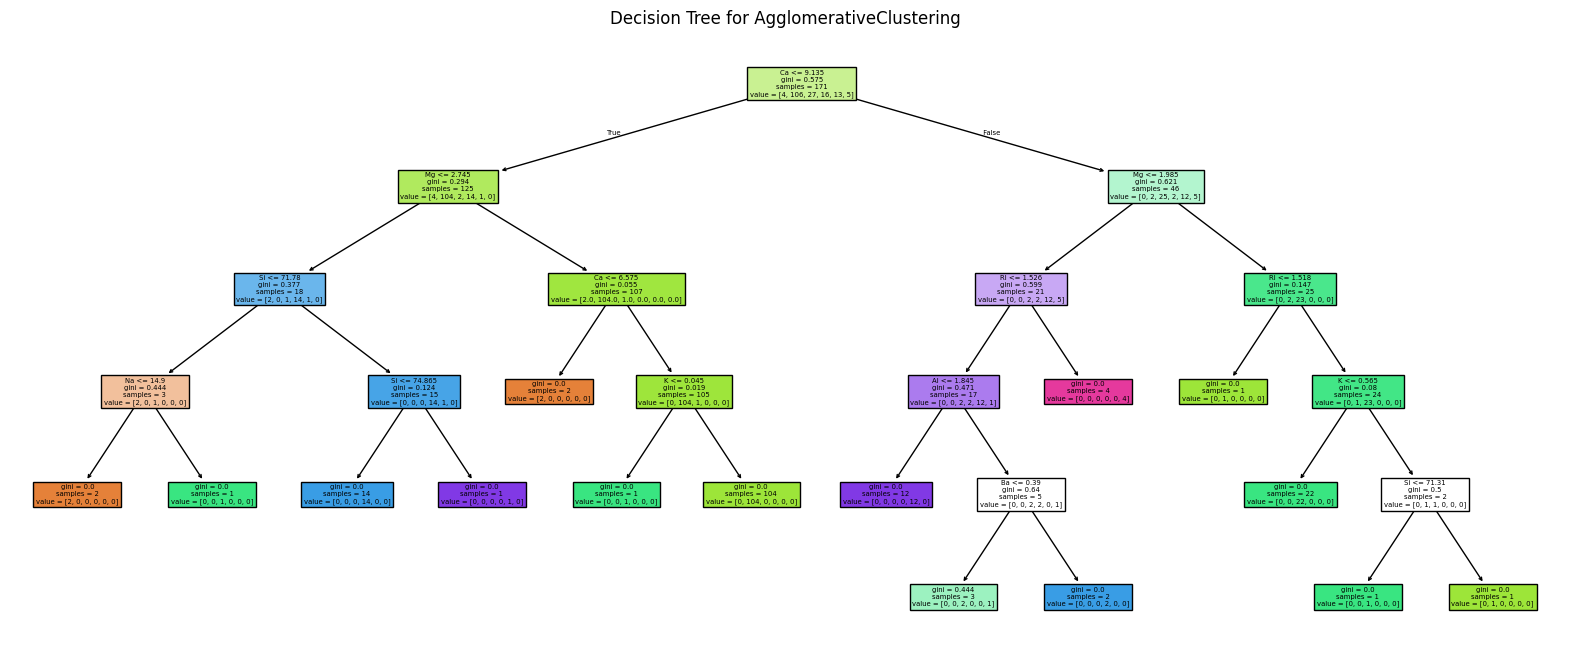

Optimization started

Training time: 4.79s, epochs: 149

Least training loss reached: 0.006
DSGD Accuracy for AgglomerativeClustering: 0.95
DSGD Rules:


Most important rules for class 0

	[0.731] R24: Ca < 7.989
			0: 0.534	1: 0.373	2: 0.000	3: 0.092	4: 0.000	5: 0.000	Unc: 0.001

	[0.720] R23: K > 0.877
			0: 0.524	1: 0.000	2: 0.000	3: 0.000	4: 0.465	5: 0.000	Unc: 0.011

	[0.570] R31: Ba > 0.520
			0: 0.325	1: 0.090	2: 0.055	3: 0.394	4: 0.000	5: 0.136	Unc: 0.001

	[0.557] R16: Si < 72.078
			0: 0.330	1: 0.221	2: 0.360	3: 0.000	4: 0.000	5: 0.030	Unc: 0.059

	[0.485] R0: RI < 1.516
			0: 0.263	1: 0.364	2: 0.000	3: 0.267	4: 0.000	5: 0.000	Unc: 0.106

	[0.422] R9: 1.867 < Mg < 2.795
			0: 0.212	1: 0.000	2: 0.431	3: 0.000	4: 0.195	5: 0.000	Unc: 0.162

	[0.415] R15: Al > 1.739
			0: 0.225	1: 0.072	2: 0.146	3: 0.324	4: 0.000	5: 0.000	Unc: 0.233

Most important rules for class 1

	[0.631] R2: 1.518 < RI < 1.521
			0: 0.000	1: 0.400	2: 0.208	3: 0.000	4: 0.291	5: 0.096	Unc: 0.004

	[0.617] R19:

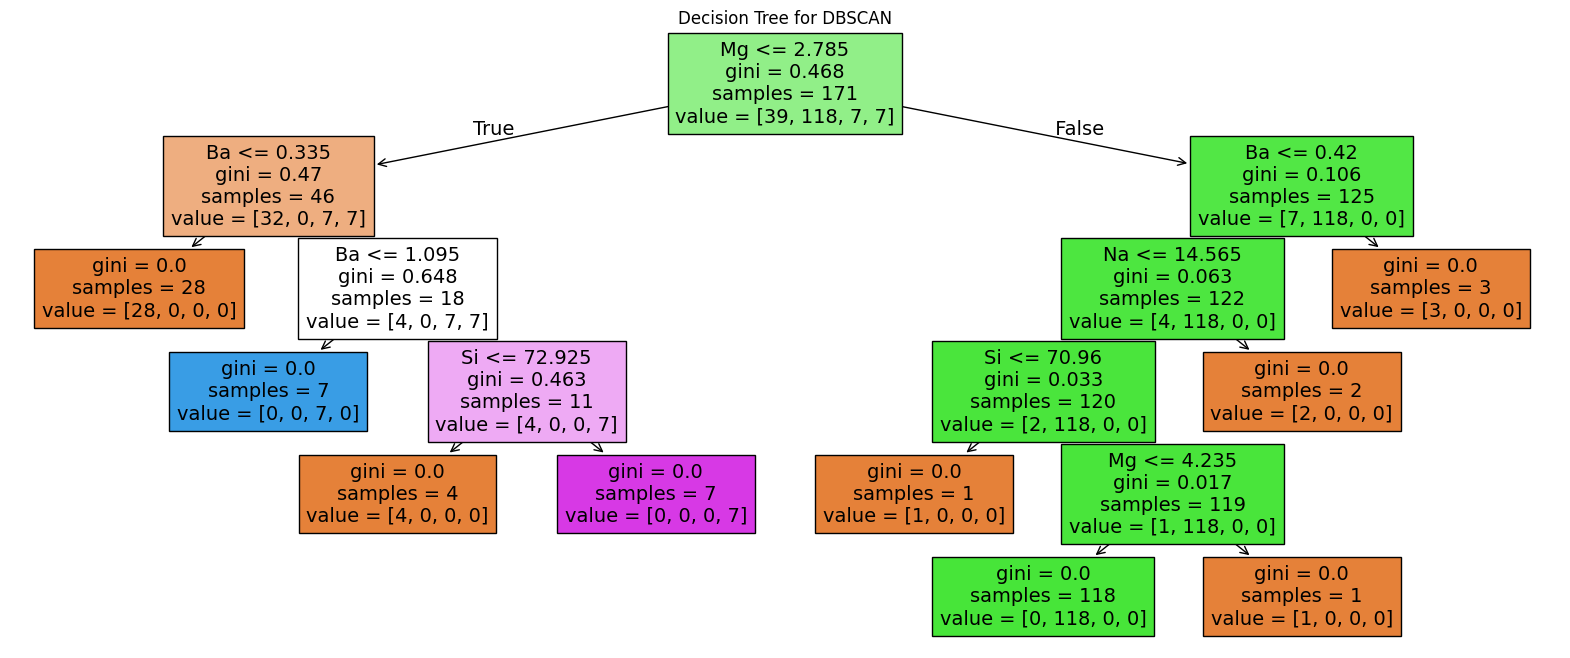

Optimization started

Training time: 5.54s, epochs: 173

Least training loss reached: 0.010
DSGD Accuracy for DBSCAN: 0.88
DSGD Rules:


Most important rules for class 0

	[0.683] R3: RI > 1.521
			0: 0.547	1: 0.000	2: 0.000	3: 0.307	Unc: 0.147

	[0.577] R24: Ca < 7.989
			0: 0.336	1: 0.000	2: 0.000	3: 0.656	Unc: 0.008

	[0.555] R0: RI < 1.516
			0: 0.308	1: 0.622	2: 0.000	3: 0.069	Unc: 0.000

	[0.553] R16: Si < 72.078
			0: 0.349	1: 0.000	2: 0.000	3: 0.528	Unc: 0.123

	[0.515] R12: Al < 1.097
			0: 0.515	1: 0.000	2: 0.000	3: 0.000	Unc: 0.485

	[0.497] R4: Na < 12.873
			0: 0.296	1: 0.000	2: 0.000	3: 0.539	Unc: 0.165

	[0.472] R6: 13.386 < Na < 13.899
			0: 0.300	1: 0.000	2: 0.000	3: 0.441	Unc: 0.259

	[0.471] R11: Mg > 3.724
			0: 0.471	1: 0.000	2: 0.000	3: 0.000	Unc: 0.529

	[0.466] R14: 1.418 < Al < 1.739
			0: 0.322	1: 0.000	2: 0.000	3: 0.354	Unc: 0.324

	[0.448] R26: 8.942 < Ca < 9.895
			0: 0.272	1: 0.380	2: 0.000	3: 0.085	Unc: 0.263

	[0.436] R22: 0.500 < K < 0.877
			0: 0.436	1

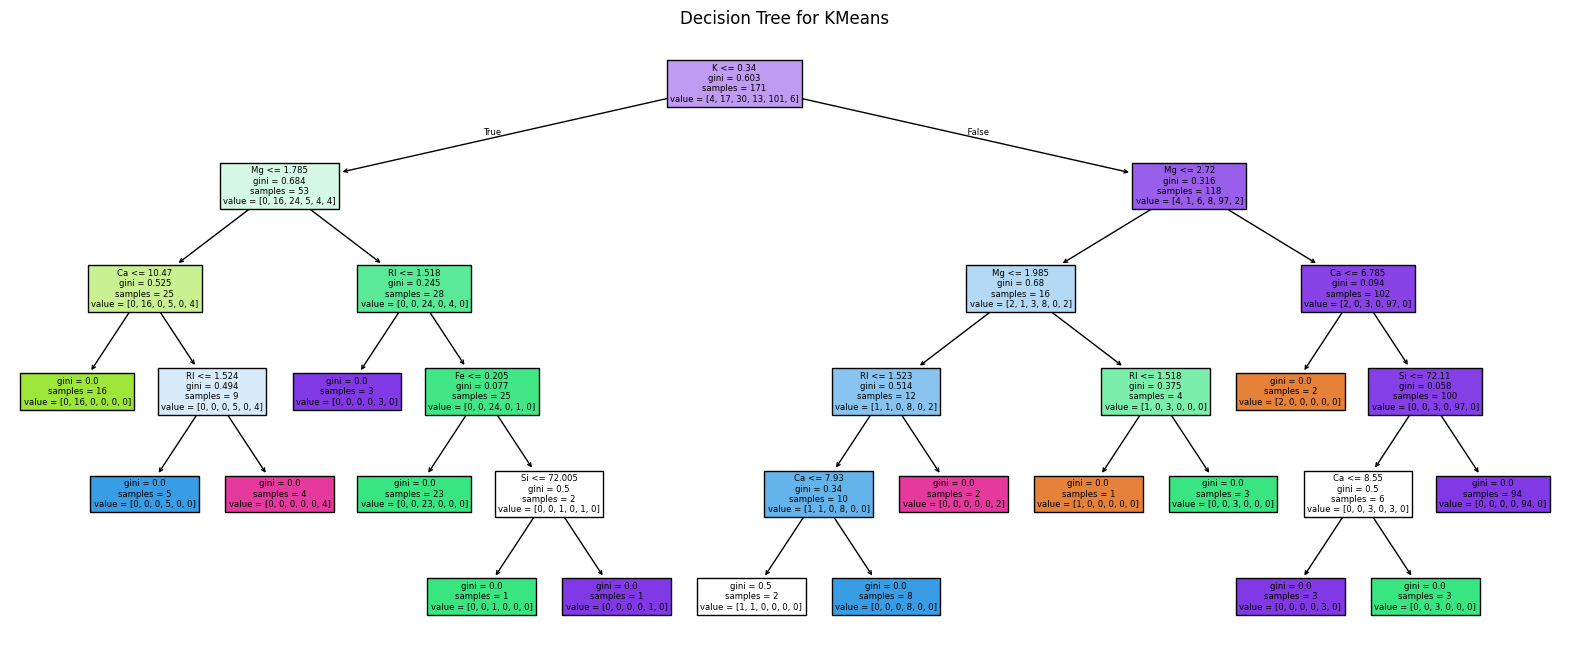

Optimization started

Training time: 4.12s, epochs: 129

Least training loss reached: 0.009
DSGD Accuracy for KMeans: 0.95
DSGD Rules:


Most important rules for class 0

	[0.702] R23: K > 0.877
			0: 0.510	1: 0.072	2: 0.000	3: 0.385	4: 0.000	5: 0.000	Unc: 0.033

	[0.669] R24: Ca < 7.989
			0: 0.474	1: 0.091	2: 0.000	3: 0.000	4: 0.379	5: 0.000	Unc: 0.056

	[0.553] R31: Ba > 0.520
			0: 0.321	1: 0.375	2: 0.258	3: 0.000	4: 0.000	5: 0.000	Unc: 0.046

	[0.534] R16: Si < 72.078
			0: 0.288	1: 0.000	2: 0.349	3: 0.010	4: 0.050	5: 0.291	Unc: 0.012

	[0.459] R0: RI < 1.516
			0: 0.243	1: 0.257	2: 0.000	3: 0.000	4: 0.367	5: 0.000	Unc: 0.134

	[0.432] R15: Al > 1.739
			0: 0.230	1: 0.395	2: 0.000	3: 0.000	4: 0.122	5: 0.062	Unc: 0.191

	[0.411] R9: 1.867 < Mg < 2.795
			0: 0.215	1: 0.000	2: 0.287	3: 0.263	4: 0.022	5: 0.000	Unc: 0.213

Most important rules for class 1

	[0.598] R31: Ba > 0.520
			0: 0.321	1: 0.375	2: 0.258	3: 0.000	4: 0.000	5: 0.000	Unc: 0.046

	[0.578] R7: Na > 13.899
			0: 0.000	

In [19]:
# interpretamos solo los mejores 3 resultados y guardamos los modelos
saved_models = {}
top_3_labels = {name: results[name] for name in top_3_algorithms.index}
top_3_data = glass.copy()
for name, labels in top_3_labels.items():
    n = len(np.unique(labels))
    X_train, X_test, y_train, y_test = train_test_split(top_3_data, labels, test_size=0.2, random_state=42)
    print(f'Processing {name} with {n} clusters')
    
    # Ripper
    ripper = MultiClassRipperClassifier(random_state=43)
    ripper.fit(X_train, y_train)
    y_pred_ripper = ripper.predict(X_test)
    print(f'Ripper Accuracy for {name}: {accuracy_score(y_test, y_pred_ripper):.2f}')
    print('Ripper Rules:')
    ripper.print_rules()
    saved_models.setdefault(name, {})['ripper'] = ripper
    
    # Decision Tree
    dtree = DecisionTreeClassifier(random_state=42, max_depth=5)
    dtree.fit(X_train, y_train)
    dtree_pred = dtree.predict(X_test)
    print(f'Decision Tree Accuracy for {name}: {accuracy_score(y_test, dtree_pred):.2f}')
    plt.figure(figsize=(20, 8))
    sk_tree.plot_tree(dtree, filled=True, feature_names=X_train.columns)
    plt.title(f'Decision Tree for {name}')
    plt.show()
    saved_models[name]['dtree'] = dtree
    
    # DSGD
    max_label = np.max(labels)
    y_train = np.where(y_train == -1, max_label + 1, y_train)
    y_test = np.where(y_test == -1, max_label + 1, y_test)
    ds = DSClassifierMultiQ(n, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
    X = X_train.to_numpy()
    losses, epoch, dt = ds.fit(X, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=X_train.columns)
    x_test = X_test.to_numpy()
    y_pred_ds = ds.predict(x_test)
    print(f'DSGD Accuracy for {name}: {accuracy_score(y_test, y_pred_ds):.2f}')
    print('DSGD Rules:')
    ds.print_most_important_rules(threshold=0.32)
    saved_models[name]['ds'] = ds
    
    print('--' * 40)
